# w207 Final Project Summer 2022

CJ Donahoe, Ben Meier, Sam Rosenberg

Question: Can we predict site energy usage from publically available building performance data?

# Step 1: Import packages

In [1]:
import os
import random

import numpy as np
import pandas as pd
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns


# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)


## Set parameters

In [2]:
# Connect notebook to google drive W207 - Final Project Folder
drive.mount('/content/drive')

# Numpy random seed
np.random.seed(0)

# Set test percentage
test_percent = 0.3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Define functions

In [3]:
def import_data():
    """Read the dataset from mounted Google Drive folder
    # param: NA
    # returns dataframe
    """
    # Files to read
    # Downloaded on 2022.06.05 from https://bpd.lbl.gov/explore
    path_data = r'/content/drive/MyDrive/W207 - Final Project/Data_2022.06.05/'
    file_dict = {
        'austin':'Austin Benchmarking Ordinance.csv',
        'berkeley':'Berkeley Benchmarking Ordinance.csv',
        'boston':'Boston Benchmarking Ordinance.csv',
        'calBEBP':'California Building Energy Benchmarking Program.csv',
        'calProp':'California Proposition 39 K-12 Program.csv',
        'cambridge':'Cambridge Benchmarking Ordinance.csv',
        'chicago':'Chicago Benchmarking Ordinance.csv',
        'fanniemae':'Fannie Mae Multifamily Survey.csv',
        'gainesville':'Gainesville Green.csv',
        'nycOrdinance':'New York City Benchmarking Ordinance (excl. audit data).csv',
        'nycResidential':'New York Residential Statewide Baseline Study.csv',
        'philadelphia':'Philadelphia Benchmarking Ordinance.csv',
        'sf':'San Francisco Benchmarking Ordinance.csv',
        'seattle':'Seattle Benchmarking Ordinance.csv',
        'syracuse':'Syracuse Benchmarking Ordinance.csv',
        'dc':'Washington D.C. Benchmarking Ordinance.csv',
    }

    # read data
    datadict = dict()
    cols = dict()
    for k in file_dict.keys():
        df = pd.read_csv(
            path_data + file_dict[k],
            low_memory=False
        )

        print('Shape of', k, df.shape)
        df.insert(0, 'datasource', k)
        datadict[k] = df

    # check if column names list matches accross datasets
    datakeys = list(file_dict.keys())
    for i in range(len(datakeys) - 1):
        cols1 = datadict[datakeys[i]].columns
        cols2 = datadict[datakeys[i+1]].columns
        if not np.array_equal(cols1, cols2):
            print("COLUMNS don't match in", datakeys[i], datakeys[i+1])
            raise Exception("IMPORT FAILED: column names don't match in all dataframes")

    # Combine all dfs into 1
    finaldf = pd.concat(datadict.values(), axis=0, ignore_index=True)

    # Add random number for test/train
    finaldf.insert(0, 'rand_num', np.random.uniform(size=len(finaldf)))
    print("Shape of combined dataset", finaldf.shape)
    return finaldf


# Step 3: Read data

In [4]:
dfin = import_data()
dfin.sample(10)

Shape of austin (8390, 32)
Shape of berkeley (414, 32)
Shape of boston (6835, 32)
Shape of calBEBP (3881, 32)
Shape of calProp (1501, 32)
Shape of cambridge (4122, 32)
Shape of chicago (11937, 32)
Shape of fanniemae (857, 32)
Shape of gainesville (154528, 32)
Shape of nycOrdinance (54298, 32)
Shape of nycResidential (439, 32)
Shape of philadelphia (6457, 32)
Shape of sf (9647, 32)
Shape of seattle (17002, 32)
Shape of syracuse (139, 32)
Shape of dc (15618, 32)
Shape of combined dataset (296065, 34)


,rand_num,datasource,id,year,zip_code,city,state,climate,building_class,facility_type,floor_area,year_built,number_of_people,occupant_density,operating_hours,lighting,air_flow_control,heating,heating_fuel,cooling,wall_type,wall_insulation_r_value,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,leed_score,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,data_source
72849,0.618615,gainesville,136706,2010,32608,Gainesville,FL,2A Hot - Humid (Houston-TX),Residential,Residential - Unknown,4572.0,1990,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Central Air Conditioning,Unknown,No Value,Asphalt/fiberglass/other shingles,Unknown,Unknown,Unknown,No Value,Unknown,31.2569953146,No Value,No Value,No Value,No Value,Gainesville Green
74034,0.462858,gainesville,136947,2011,32606,Gainesville,FL,2A Hot - Humid (Houston-TX),Residential,Residential - Unknown,2438.0,1989,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Central Air Conditioning,Unknown,No Value,Asphalt/fiberglass/other shingles,Unknown,Unknown,Unknown,No Value,Unknown,22.1510180922,32.4374283278,53.6648738408,102.6437453455,5.1063946991,Gainesville Green
23959,0.916405,cambridge,614-8,2018,Unknown,Cambridge,MA,5A Cool - Humid (Chicago-IL),Residential,Multifamily - Uncategorized,322673.0,2008,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,Unknown,Unknown,Unknown,42,Unknown,27.5448682256,61.7354445522,89.2803127778,151.3008107000,5.2170206851,Cambridge Benchmarking Ordinance
73809,0.121757,gainesville,136902,2013,32608,Gainesville,FL,2A Hot - Humid (Houston-TX),Residential,Residential - Unknown,2129.0,1996,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Central Air Conditioning,Unknown,No Value,Asphalt/fiberglass/other shingles,Unknown,Unknown,Unknown,No Value,Unknown,15.4230967098,24.7539705138,38.7679227921,72.9405910552,3.5060328391,Gainesville Green
119754,0.532571,gainesville,148687,2011,32607,Gainesville,FL,2A Hot - Humid (Houston-TX),Residential,Residential - Unknown,5711.0,2006,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,31.0835024500,No Value,51.0019460413,118.5165634638,5.8748041482,Gainesville Green
277230,0.873814,seattle,46427,2015,98122,Seattle,WA,4C Mixed - Marine (Salem-OR),Residential,5+ Unit Building,75025.0,2012,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,Unknown,Unknown,Unknown,98,Unknown,25.8655836189,8.2251389223,34.0907225412,89.8543284319,3.1327826195,Seattle Benchmarking Ordinance
101710,0.344928,gainesville,143829,2014,32609,Gainesville,FL,2A Hot - Humid (Houston-TX),Residential,Residential - Unknown,1418.0,1968,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Central Air Conditioning,Unknown,No Value,Asphalt/fiberglass/other shingles,Unknown,Unknown,Unknown,No Value,Unknown,7.4164002692,14.1752178523,21.5916181215,38.1714755902,1.8223932341,Gainesville Green
211049,0.211788,nycOrdinance,1016090001,2017,10029,New York,NY,4A Mixed - Humid (Baltimore-MD),Commercial,Public Assembly - Entertainment/culture,113915.0,1929,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,No Value,No Value,158.3000000000,356.5000000000,No Value,New York City Benchmarking Ordinance (excl. au...
249399,0.425356,philadelphia,3673605,2014,19136,Philadelphia,PA,4A Mixed - Humid (Baltimore-MD),Commercial,Warehouse - Self-storage,85350.0,2006,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,51.1059722079,1.1627370296,52.2687092375,161.6936266140,5.7304450929,Philadelphia Benchmarking Ordinance
12605,0.850938,boston,203506010,2017,02129,Charlestown,MA,5A Cool - Humid (Chicago-IL),Residential,Multifamily - Uncategorized,320568.0,1979,No Value,No Value,

In [5]:
dfin.describe()

,rand_num,year,floor_area
count,296065.000000,296065.000000,2.960650e+05
mean,0.499945,2013.978505,7.469098e+04
std,0.288813,2.609692,1.796745e+05
min,0.000003,2010.000000,5.000000e+02
25%,0.248980,2012.000000,1.635000e+03
50%,0.500718,2014.000000,3.260000e+03
75%,0.750343,2016.000000,8.036400e+04
max,0.999999,2020.000000,6.385382e+06


# Step 4: Exploratory Data Analysis (EDA)

Detailed column definitions can be found here:

- Identify NAs
- Identify most frequent values
- Clean data
- Verify df is ready for preprocessing

## Identify primary keys

Primary keys are: `['datasource', 'id', 'year']`

In [6]:
dfin[['id', 'year']].value_counts(dropna=False)

id       year
160270   2015    2
67       2017    2
128292   2015    2
137      2017    2
159417   2015    2
                ..
147143   2010    1
147141   2015    1
         2014    1
         2013    1
R544517  2017    1
Length: 295865, dtype: int64

In [7]:
slice = (dfin.id==160270) & (dfin.year==2015)
dfin.loc[slice, :]

,rand_num,datasource,id,year,zip_code,city,state,climate,building_class,facility_type,floor_area,year_built,number_of_people,occupant_density,operating_hours,lighting,air_flow_control,heating,heating_fuel,cooling,wall_type,wall_insulation_r_value,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,leed_score,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,data_source
30127,0.786091,chicago,160270,2015,60654,Chicago,IL,5A Cool - Humid (Chicago-IL),Residential,Multifamily - Uncategorized,497185.0,2007,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No Value,Unknown,Unknown,Unknown,Unknown,37,Unknown,31.4696731175,55.0472540495,86.5169271670,156.6143903408,8.4497708331,Chicago Benchmarking Ordinance
164378,0.817141,gainesville,160270,2015,32603,Gainesville,FL,2A Hot - Humid (Houston-TX),Residential,Residential - Unknown,1695.0,1975,No Value,No Value,No Value,Unknown,Unknown,Unknown,Unknown,Central Air Conditioning,Unknown,No Value,Asphalt/fiberglass/other shingles,Unknown,Unknown,Unknown,No Value,Unknown,No Value,26.4312819200,No Value,No Value,No Value,Gainesville Green


The building `id` is not distinct across datasets, so must add datasource to pk identification

In [8]:
dfin[['datasource', 'id', 'year']].value_counts(dropna=False)

datasource   id      year
austin       100012  2018    1
gainesville  164779  2012    1
             164791  2012    1
                     2011    1
                     2010    1
                            ..
             139122  2010    1
             139121  2013    1
                     2012    1
                     2011    1
syracuse     141     2017    1
Length: 296065, dtype: int64

## Identify NAs

In [9]:
dfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296065 entries, 0 to 296064
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   rand_num                 296065 non-null  float64
 1   datasource               296065 non-null  object 
 2   id                       296065 non-null  object 
 3   year                     296065 non-null  int64  
 4   zip_code                 296065 non-null  object 
 5   city                     296065 non-null  object 
 6   state                    296065 non-null  object 
 7   climate                  296065 non-null  object 
 8   building_class           296065 non-null  object 
 9   facility_type            296065 non-null  object 
 10  floor_area               296065 non-null  float64
 11  year_built               296065 non-null  object 
 12  number_of_people         296065 non-null  object 
 13  occupant_density         296065 non-null  object 
 14  oper

There are no NaN values in the dataframe. Most columns are object type except for floor_area.

## Feature analysis by dataset

In [10]:
ds_list = dfin.datasource.drop_duplicates().to_list()

for ds in ds_list:
    temp = dfin.loc[dfin.datasource==ds, :]
    print("\n", ds.upper(), "- ROWS:", temp.shape[0], "-"*20)
    print(temp.info())


 AUSTIN - ROWS: 8390 --------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8390 entries, 0 to 8389
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rand_num                 8390 non-null   float64
 1   datasource               8390 non-null   object 
 2   id                       8390 non-null   object 
 3   year                     8390 non-null   int64  
 4   zip_code                 8390 non-null   object 
 5   city                     8390 non-null   object 
 6   state                    8390 non-null   object 
 7   climate                  8390 non-null   object 
 8   building_class           8390 non-null   object 
 9   facility_type            8390 non-null   object 
 10  floor_area               8390 non-null   float64
 11  year_built               8390 non-null   object 
 12  number_of_people         8390 non-null   object 
 13  occupant_density         8390 non-n

## Most frequent column values

In [11]:
# Most frequenty values by column
for col in dfin.columns:
    print("\n", col.upper(), "- number of distinct vals:", len(dfin[col].value_counts()), "-"*20)
    print(dfin[col].value_counts(dropna=False).head())


 RAND_NUM - number of distinct vals: 296065 --------------------
0.548814    1
0.454976    1
0.341321    1
0.867747    1
0.154286    1
Name: rand_num, dtype: int64

 DATASOURCE - number of distinct vals: 16 --------------------
gainesville     154528
nycOrdinance     54298
seattle          17002
dc               15618
chicago          11937
Name: datasource, dtype: int64

 ID - number of distinct vals: 78211 --------------------
160196    12
132117    11
161204    11
165439    11
159981    11
Name: id, dtype: int64

 YEAR - number of distinct vals: 11 --------------------
2013    39902
2012    39004
2015    36720
2014    34593
2011    33852
Name: year, dtype: int64

 ZIP_CODE - number of distinct vals: 1632 --------------------
32605      37371
32606      21298
Unknown    20458
32607      19015
32653      16999
Name: zip_code, dtype: int64

 CITY - number of distinct vals: 736 --------------------
Gainesville    150996
New York        23911
Seattle         17002
Washington      15619


---------
**Cleaning required:**
- data_source
    - is redundant with datasource?
- fix year_built
    - investigate why 510 distinct values
- Create location column for one-hot encodings?
    - combine city, state, zip (ignore Unknowns)
- drop:
    - number_of_people
    - occupant_density
    - operating_hours
    - lighting
    - air_flow_control
    - heating_fuel
    - wall_insulation_r_value
    - leed_Score

**Discuss as group:**
- Recode unknowns, no value, and missings as np.nan?
- Discuss columns with No Value for:
    - electric_eui
    - fuel_eui
    - site_eui
    - source_eui

--------------

### data_source

In [12]:
dfin[['data_source', 'datasource']].value_counts()
dfin.drop(columns=['data_source'], inplace=True)

### year_built

All values can be converted to float except for 'No Value' which will become np.nan

In [13]:
dfin['year_built'].value_counts()

dfin['year_built'] = dfin.year_built.replace('No Value', np.nan).astype(float)
dfin.year_built.value_counts(dropna=False)

1975.0    6799
1980.0    6578
1983.0    6533
1984.0    6006
2000.0    5939
1970.0    5808
2005.0    5629
1985.0    5614
1969.0    5585
1968.0    5285
1976.0    5098
1999.0    4986
1972.0    4945
2004.0    4943
1978.0    4910
1979.0    4891
2001.0    4804
NaN       4779
2006.0    4698
1965.0    4566
1987.0    4558
2002.0    4533
1973.0    4482
1981.0    4449
1990.0    4426
2003.0    4402
1997.0    4362
1974.0    4316
1998.0    4311
1989.0    4269
1986.0    4260
1988.0    4236
1971.0    4035
1964.0    3834
1995.0    3817
1996.0    3708
1992.0    3601
1994.0    3577
1991.0    3506
1982.0    3438
1963.0    3347
1967.0    3344
1993.0    3293
1960.0    3270
1977.0    3155
1966.0    2964
1962.0    2952
1930.0    2742
1920.0    2681
1928.0    2680
1927.0    2641
1929.0    2596
1925.0    2536
1961.0    2323
1926.0    2314
1950.0    2216
1959.0    2207
1900.0    2053
1931.0    2000
2008.0    1866
1924.0    1865
2007.0    1793
2009.0    1781
1910.0    1748
1958.0    1723
1940.0    1568
1955.0    

### City line

In [14]:
dfin['city_line'] = dfin.city.str.strip() + ', ' + dfin.state.str.strip() + ' ' + dfin.zip_code.astype(str)
dfin.drop(columns=['city', 'state', 'zip_code'], inplace=True)
dfin.city_line.value_counts(dropna=False)

Gainesville, FL 32605      37371
Gainesville, FL 32606      21298
Gainesville, FL 32607      19015
Gainesville, FL 32653      16999
Gainesville, FL 32608      16805
                           ...  
Hamilton City, CA 95951        1
Elverta, CA 95626              1
Fresno, CA 93704               1
Carlotta, CA 95528             1
Glendale, CA 91201             1
Name: city_line, Length: 1722, dtype: int64

### Drop columns with no data

In [15]:
cols = [
    'number_of_people',
    'occupant_density',
    'operating_hours',
    'lighting',
    'air_flow_control',
    'heating_fuel',
    'wall_insulation_r_value',
    'leed_score',
]
dfin.drop(columns=cols, inplace=True)

### convert missing values to NA

In [16]:
dfin = (
    dfin
    .replace("No Value*\S", np.nan, regex=True)
    .replace("Unknown*\S", np.nan, regex=True)
)

### Convert numeric data to float datatype

In [17]:
dfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296065 entries, 0 to 296064
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   rand_num             296065 non-null  float64
 1   datasource           296065 non-null  object 
 2   id                   296065 non-null  object 
 3   year                 296065 non-null  int64  
 4   climate              295242 non-null  object 
 5   building_class       296065 non-null  object 
 6   facility_type        139124 non-null  object 
 7   floor_area           296065 non-null  float64
 8   year_built           291286 non-null  float64
 9   heating              237 non-null     object 
 10  cooling              150688 non-null  object 
 11  wall_type            439 non-null     object 
 12  roof_ceiling         153910 non-null  object 
 13  window_glass_layers  1665 non-null    object 
 14  window_glass_type    53 non-null      object 
 15  energy_star_label

In [18]:
num_cols = [
    'year',
    'floor_area',
    'year_built',
    'energy_star_rating',
    'electric_eui',
    'fuel_eui',
    'site_eui',
    'source_eui',
    'ghg_emissions_int',
]

dfin.loc[:, num_cols] = dfin[num_cols].astype(float)
dfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296065 entries, 0 to 296064
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   rand_num             296065 non-null  float64
 1   datasource           296065 non-null  object 
 2   id                   296065 non-null  object 
 3   year                 296065 non-null  float64
 4   climate              295242 non-null  object 
 5   building_class       296065 non-null  object 
 6   facility_type        139124 non-null  object 
 7   floor_area           296065 non-null  float64
 8   year_built           291286 non-null  float64
 9   heating              237 non-null     object 
 10  cooling              150688 non-null  object 
 11  wall_type            439 non-null     object 
 12  roof_ceiling         153910 non-null  object 
 13  window_glass_layers  1665 non-null    object 
 14  window_glass_type    53 non-null      object 
 15  energy_star_label

## Verify data is ready for preprocessing



In [19]:
# Most frequenty values by column
for col in dfin.columns:
    print("\n", col.upper(), "- number of distinct vals:", len(dfin[col].value_counts()), "-"*20)
    print(dfin[col].value_counts(dropna=False).head(20))


 RAND_NUM - number of distinct vals: 296065 --------------------
0.548814    1
0.454976    1
0.341321    1
0.867747    1
0.154286    1
0.935424    1
0.073475    1
0.474760    1
0.957960    1
0.559827    1
0.321917    1
0.277953    1
0.056276    1
0.645790    1
0.841066    1
0.192165    1
0.801375    1
0.854944    1
0.455857    1
0.780529    1
Name: rand_num, dtype: int64

 DATASOURCE - number of distinct vals: 16 --------------------
gainesville       154528
nycOrdinance       54298
seattle            17002
dc                 15618
chicago            11937
sf                  9647
austin              8390
boston              6835
philadelphia        6457
cambridge           4122
calBEBP             3881
calProp             1501
fanniemae            857
nycResidential       439
berkeley             414
syracuse             139
Name: datasource, dtype: int64

 ID - number of distinct vals: 78211 --------------------
160196       12
132117       11
161204       11
165439       11
159981 

In [20]:
dfin.sample(10)

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line
235013,0.294697,nycOrdinance,3068360050,2014.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,97030.0,1958.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN,48.453452,71.480957,NaN,"Brooklyn, NY 11229"
155399,0.385703,gainesville,157561,2011.0,2A Hot - Humid (Houston-TX),Residential,NaN,1053.0,1970.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,20.792418,20.448028,41.240446,86.758623,4.302326,"Gainesville, FL 32601"
191885,0.238374,gainesville,168057,2013.0,2A Hot - Humid (Houston-TX),Residential,NaN,936.0,1984.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,29.087699,NaN,NaN,NaN,NaN,NaN
264927,0.280738,seattle,20167,2017.0,4C Mixed - Marine (Salem-OR),Commercial,Education - Other classroom,21600.0,1957.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,29.107719,33.688474,62.796193,126.771135,4.301945,"Seattle, WA 98121"
190863,0.979326,gainesville,167725,2013.0,2A Hot - Humid (Houston-TX),Residential,NaN,1110.0,1983.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,22.330046,NaN,NaN,NaN,NaN,NaN
77703,0.635207,gainesville,137788,2014.0,2A Hot - Humid (Houston-TX),Residential,NaN,3983.0,1994.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,12.976366,NaN,24.123997,52.450801,2.456388,"Gainesville, FL 32606"
177932,0.658725,gainesville,163714,2011.0,2A Hot - Humid (Houston-TX),Residential,NaN,1274.0,1975.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,32.977574,39.386628,74.853242,147.519034,7.429004,NaN
172356,0.682061,gainesville,162286,2013.0,2A Hot - Humid (Houston-TX),Residential,NaN,2257.0,1980.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,25.150934,8.418447,32.860458,87.068932,4.104999,"Gainesville, FL 32607"
199876,0.610756,nycOrdinance,1008600022,2015.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,120745.0,1938.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,84.088715,130.786726,NaN,"New York, NY 10016"
254235,0.357762,sf,0141/013,2013.0,3C Warm - Marine (San Francisco-CA),Commercial,Office - Uncategorized,16473.0,1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN,28.200000,71.700000,NaN,"San Francisco, CA 94111"


In [21]:
num_cols = [
    'floor_area', 'year_built', 'site_eui', 'electric_eui', 'fuel_eui'
]
dfin[num_cols].describe()

,floor_area,year_built,site_eui,electric_eui,fuel_eui
count,2.960650e+05,291286.000000,204210.000000,200966.000000,160800.000000
mean,7.469098e+04,1971.887276,63.231037,29.602798,23.291331
std,1.796745e+05,28.742165,54.413696,28.690731,32.060086
min,5.000000e+02,1649.000000,1.001169,0.000000,0.000000
25%,1.635000e+03,1961.000000,32.009412,16.253904,8.182419
50%,3.260000e+03,1978.000000,50.051977,23.384545,15.138294
75%,8.036400e+04,1993.000000,79.382514,33.968446,26.041885
max,6.385382e+06,2020.000000,997.866120,987.466930,936.379589


In [22]:
txt_cols = [
    'climate', 'building_class', 'facility_type'
]
dfin[txt_cols].describe()

for col in txt_cols:
    print("\n", col.upper(), "- number of distinct vals:", len(dfin[col].value_counts()), "-"*20)
    print(dfin[col].value_counts(dropna=False).head(10))


 CLIMATE - number of distinct vals: 12 --------------------
2A Hot - Humid (Houston-TX)            162918
4A Mixed - Humid (Baltimore-MD)         76484
5A Cool - Humid (Chicago-IL)            23269
4C Mixed - Marine (Salem-OR)            17039
3C Warm - Marine (San Francisco-CA)     11171
3B Warm - Dry (El Paso-TX)               3957
NaN                                       823
6A Cold - Humid (Burlington-VT)           183
4B Mixed - Dry (Albuquerque-NM)            95
5B Cool - Dry (Boise-ID)                   67
Name: climate, dtype: int64

 BUILDING_CLASS - number of distinct vals: 2 --------------------
Residential    223601
Commercial      72464
Name: building_class, dtype: int64

 FACILITY_TYPE - number of distinct vals: 82 --------------------
NaN                                  156941
Multifamily - Uncategorized           56268
Office - Uncategorized                22030
Education - Other classroom            8350
2-4 Unit Building                      5018
5+ Unit Building  

### PICKLE: data in, no preprocessing

In [23]:
dfin.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704"
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704"
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704"
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704"
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704"


In [24]:
path_train = r'/content/drive/MyDrive/W207 - Final Project/pickles/dffinal_no_preprocess_train.pk1'
path_test = r'/content/drive/MyDrive/W207 - Final Project/pickles/dffinal_no_preprocess_test.pk1'

df_test = dfin[dfin.rand_num < test_percent]
df_train = dfin[dfin.rand_num >= test_percent]
df_test.to_pickle(path_test)
df_train.to_pickle(path_train)

print("test:", df_test.shape, "train:", df_train.shape)


test: (88949, 23) train: (207116, 23)


# Step 5: Data preprocessing

- Identify labeled data columns
    - site_eui
    - source_eui
        - Subsets of source (electric_eui, fuel_eui)
- Create one-hot and multi-hot columns
    - climate 
        - break into two variables, temp and humidity
        - Group them into 1 of 3 categories, then multi-hot?
    - building_class
    - facility_type
    - year
- Special column maniupulation
    - convert year-built into 'years old' column using year_built and year?
- Drop rows with significant missing data?
    - Site EUI missing for 1/3 of dataset: 91855 rows
- Drop columns with significant missing data intitially for performance reasons?
    - window_glass_type
    - energy_star_label

## Create one-hot and multi-hot columns

In [25]:
df_mh = dfin.copy()
dfin.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704"
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704"
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704"
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704"
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704"


In [26]:
from copy import deepcopy
# Create multi-hot climate
col = 'climate'

#categorical data
mh = dfin[col].drop_duplicates().to_list()

# Shorten to remove city/state
mh = ['clim_' + val[:val.find(" (")] for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin[col])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# Create multi-hot Building class
col = 'building_class'

#categorical data
mh = dfin[col].drop_duplicates().to_list()
mh = ['BC_' + val for val in mh]

df = pd.get_dummies(dfin[col])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [28]:
# Create multi-hot facility_type
col = 'facility_type'
# Simplify facility_types: Singlefamily, Multifamily, Industrial, Office, Retail, Other, Hotel, Restaurant, Grocery, 
recat = {'Multifamily - Uncategorized':'Multifamily',
    'Warehouse - Uncategorized':"Industrial",
    'Industrial':"Industrial",
    'Office - Medical non diagnostic':"Office",
    'Retail - Uncategorized':"Retail",
    'Religious worship':"Office",
    'Office - Uncategorized':"Office",
    'Public Assembly - Recreation':"Other",
    'Nursing Home':"Hotel",
    'Commercial - Other':"Retail",
    'Food Service - Restaurant or cafeteria':"Restaurant",
    'Grocery store or food market':"Grocery",
    'Retail - Vehicle dealership/showroom':"Retail",
    'Warehouse - Non-refrigerated':"Industrial",
    'Health Care - Uncategorized':"Hospital",
    'Office - Bank or other financial':"Office",
    'Service - Vehicle service/repair shop':"Industrial",
    'Lodging - Hotel':"Hotel",
    'Data Center':"Data Center",
    'Education - Uncategorized':"Office",
    'Health Care - Inpatient':"Hospital",
    'Retail - Strip shopping mall':"Retail",
    'Education - College or university':"Office",
    'Warehouse - Self-storage':"Industrial",
    '5+ Unit Building':"Multifamily",
    'Mixed Use - Commercial and Residential':"Hotel",
    'Mixed Use - Predominantly Commercial':"Retail",
    'Education - Other classroom':"Office",
    'Public Assembly - Uncategorized':"Office",
    'Lodging - Dormitory or fraternity/sorority':"Hotel",
    'Warehouse - Distribution or Shipping center':"Industrial",
    'Parking Garage':"Other",
    'Laboratory':"Other",
    'Education - Preschool or daycare':"Office",
    'Service - Uncategorized':"Retail",
    'Lodging - Uncategorized':"Hotel",
    'Public Assembly - Entertainment/culture':"Retail",
    'Public Assembly - Arena':"Other",
    'Public Assembly - Movie Theater':"Other",
    'Health Care - Outpatient Uncategorized':"Hospital",
    'Public Assembly - Drama theater':"Other",
    'Public Safety - Courthouse':"Office",
    'Food Sales':"Restaurant",
    'Public Assembly - Library':"Office",
    'Office - Administrative or Professional':"Office",
    'Multifamily - Condominiums':"Multifamily",
    'Public Assembly - Social/meeting':"Office",
    'Public Safety - Fire or police station':"Office",
    'Residential - Other':"Other",
    'Food Service - Other':"Restaurant",
    'Retail - Enclosed mall':"Retail",
    'Food Service - Uncategorized':"Restaurant",
    'Health Care - Outpatient Clinic':"Hospital",
    'Lodging - Other':"Hotel",
    'Service - Industrial shop':"Industrial",
    'Public Assembly - Stadium':"Other",
    'Lodging - Motel or inn':"Hotel",
    'Vacant':"Other",
    'Mixed Use - Predominantly Residential':"Multifamily",
    'Warehouse - Refrigerated':"Grocery",
    'Public Assembly - Other':"Office",
    'Service - Other service':"Other",
    'Transportation Terminal':"Other",
    'Public Assembly - Large Hall':"Office",
    'Public Safety - Penitentiary':"Hotel",
    'Food Service - Fast food':"Restaurant",
    'Education - High school':"Office",
    'Education - Elementary or middle school':"Office",
    'Service - Post office or postal center':"Retail",
    'Convenience store':"Retail",
    'Single Family - Detached':"Singlefamily",
    'Single Family - Attached':"Singlefamily",
    'Manufactured Home':"Singlefamily",
    'Single Family - Uncategorized':'Singlefamily',
    'Service - Dry-cleaning or Laundry':'Retail',
    '2-4 Unit Building':"Multifamily",
    'Office - Other':"Office",
    'Public Assembly - Pool':"Other",
    'Service - Repair shop':"Industrial",
    'Public Safety - Uncategorized':"Other",
    'Office - Mixed use':"Office",
    'Retail - Big Box (> 50K sf)':"Retail"
    }

# Create column
dfin['facility_type_consol'] = dfin[col].replace(recat)

# #categorical data
mh = dfin['facility_type_consol'].drop_duplicates().to_list()
mh = ['FT_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin['facility_type_consol'])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Create multi-hot window_glass_layers
col = 'window_glass_layers'

#categorical data
mh = dfin[col].drop_duplicates().to_list()
mh = ['WGL_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin[col])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# Create multi-hot window_glass_type
col = 'window_glass_type'

#categorical data
mh = dfin[col].drop_duplicates().to_list()
mh = ['WGT_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin[col])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# Create multi-hot roof_ceiling
col = 'roof_ceiling'

#categorical data
mh = dfin[col].drop_duplicates().to_list()
mh = ['roof_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin[col])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
# Create multi-hot cooling
col = 'cooling'
# Simplify facility_types: Central AC, Split AC, Other, No Cooling, Cooling_Heat Pump
recat = {'Chiller - Uncategorized':"Central AC",
    'Central Air Conditioning':"Central AC",
    'No cooling':"No cooling",
    'Other Or Combination':"Other",
    'Heat Pump - Air Source':"Cooling_Heat Pump",
    'PTAC':"Split AC",
    'Split AC System':"Split AC",
    'Heat Pump - Uncategorized':"Cooling_Heat Pump",
    'Packaged Direct Expansion':"Central AC"
    }

# Create column
dfin['cooling_consol'] = dfin[col].replace(recat)

# #categorical data
mh = dfin['cooling_consol'].drop_duplicates().to_list()
mh = ['cool_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin['cooling_consol'])
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Create multi-hot heating
col = 'heating'
# Simplify facility_types: Boiler, Heating_Heat pump, Resistance Heating, Heating_Furnace, Other
recat = {'Boiler - Uncategorized':"Boiler",
    'Resistance Heating':"Resistance Heating",
    'Heat Pump - Water Loop':"Heating_Heat pump",
    'Heat Pump - Air Source':"Heating_Heat pump",
    'Perimeter Baseboard':"Other",
    'Furnace':"Heating_Furnace",
    'Other Or Combination':"Other",
    'Boiler - Steam':"Boiler",
    'Heat Pump - Ground Source':"Heating_Heat pump",
    'Heat Pump - Uncategorized':"Heating_Heat pump",
    'Central Heating':"Heating_Furnace"
    }

# Create column
dfin['heating_consol'] = dfin[col].replace(recat)

# #categorical data
mh = dfin['heating_consol'].drop_duplicates().to_list()
mh = ['heat_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin['heating_consol'], columns = mh)
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Create multi-hot
col = 'wall_type'
# Simplify facility_types: Other, Wood, Metal, Brick_stone, Concrete
recat = {'Other Or Combination':"Other",
    'Wood Walls':"wall_Wood",
    'Metal - Uncategorized':"wall_Metal",
    'Brick':"wall_Brick_stone",
    'Concrete - Uncategorized':"wall_Concrete",
    'Stone':"wall_Brick_stone"
    }

# Create column
dfin['wt_consol'] = dfin[col].replace(recat)

# #categorical data
mh = dfin['wt_consol'].drop_duplicates().to_list()
mh = ['wall_' + val for val in mh if isinstance(val, str)]

df = pd.get_dummies(dfin['wt_consol'], columns = mh)
df.columns = mh
df_mh = pd.concat([df_mh, df], axis=1)
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### PICKLE: data final, multihot

In [35]:
df_mh.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
test_percent

path_train = r'/content/drive/MyDrive/W207 - Final Project/pickles/dffinal_multihot_train.pk1'
path_test = r'/content/drive/MyDrive/W207 - Final Project/pickles/dffinal_multihot_test.pk1'

df_test = df_mh[df_mh.rand_num < test_percent]
df_train = df_mh[df_mh.rand_num >= test_percent]
df_test.to_pickle(path_test)
df_train.to_pickle(path_train)

print("test:", df_test.shape, "train:", df_train.shape)

test: (88949, 75) train: (207116, 75)


## Visualize with pairplot
Standardize Data for pairplot for baseline presentation

In [37]:
cols = ['floor_area', 'year_built', 'energy_star_rating', 'electric_eui', 'site_eui'] #'ghg_emissions_int', 'source_eui', 'fuel_eui']
temp = dfin[cols].copy()

sc = StandardScaler()
sc.fit(temp)
temp_std = sc.transform(temp)

temp = pd.DataFrame(temp_std)
temp.columns = cols
temp.describe()

,floor_area,year_built,energy_star_rating,electric_eui,site_eui
count,2.960650e+05,2.912860e+05,8.954300e+04,2.009660e+05,2.042100e+05
mean,-2.764748e-17,-9.330438e-17,3.285178e-17,-1.923386e-17,-2.413361e-16
std,1.000002e+00,1.000002e+00,1.000006e+00,1.000002e+00,1.000002e+00
min,-4.129196e-01,-1.123394e+01,-2.138007e+00,-1.031792e+00,-1.143646e+00
25%,-4.066026e-01,-3.787917e-01,-7.543966e-01,-4.652697e-01,-5.737839e-01
50%,-3.975585e-01,2.126748e-01,2.141306e-01,-2.167344e-01,-2.422017e-01
75%,3.157392e-02,7.345571e-01,8.367552e-01,1.521627e-01,2.968281e-01
max,3.512298e+01,1.673945e+00,1.321019e+00,3.338592e+01,1.717651e+01


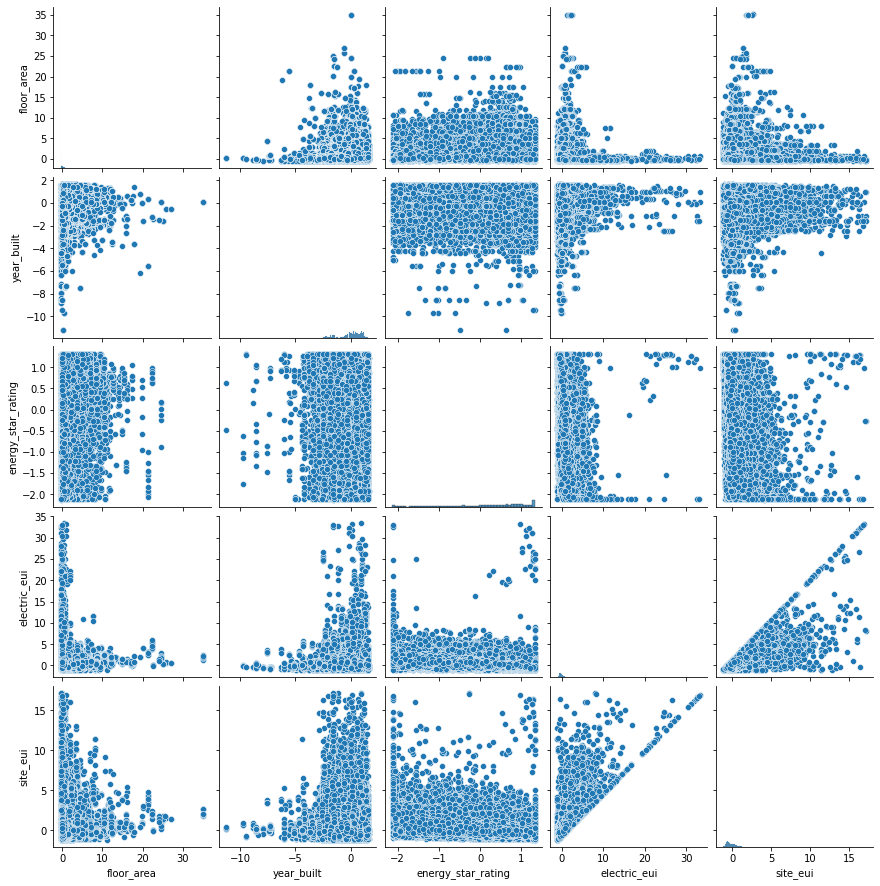

In [38]:
sns.pairplot(temp)

### Drop text columns and create numpy matrix

In [39]:
# Drop remaining text columns
dffinal = df_mh.drop(columns=['energy_star_label', 'datasource', 'city_line']).copy()
dffinal

,rand_num,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete
0,0.548814,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.000000,28.656706,89.982058,3.565981,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.000000,29.493681,92.610158,3.670133,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,37.971292,0.000000,37.971292,119.229858,4.725069,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.544883,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,39.017660,0.000000,39.017660,122.515452,4.855277,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.423655,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296060,0.325828,PM9961603,2018.0,4A Mixed - Humid (Baltimore-MD),Commercial,Office - Uncategorized,69230.0,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,31.308069,113.157134,289.879535,9.496571,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296061,0.070893,PM9961603,2019.0,4A Mixed - Humid (Baltimore-MD),Commercial,Office - Uncategorized,69230.0,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,78.0,39.458275,26.053899,65.512175,151.255579,5.160286,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296062,0.381069,PM9961603,2020.0,4A Mixed - Humid (Baltimore-MD),Commercial,Office - Uncategorized,69230.0,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,75.0,36.135220,20.551282,56.686502,135.043438,4.549992,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296063,0.419229,PM9961605,2019.0,4A Mixed - Humid (Baltimore-MD),Commercial,Office - Uncategorized,50163.0,1963.0,NaN,NaN,NaN,NaN,NaN,NaN,66.0,60.495258,36.594459,97.089717,228.379293,7.733552,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,

In [40]:
dffinal.shape

(296065, 72)

In [41]:
dffinal.describe()

,rand_num,year,floor_area,year_built,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete
count,296065.000000,296065.000000,2.960650e+05,291286.000000,89543.000000,200966.000000,160800.000000,204210.000000,196936.000000,143854.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.00000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000
mean,0.499945,2013.978505,7.469098e+04,1971.887276,61.809511,29.602798,23.291331,63.231037,126.836547,4.937401,0.550278,0.000169,0.000027,0.013365,0.037732,0.258335,0.000321,0.057552,0.078594,0.000226,0.000618,0.000003,0.244757,0.755243,0.000351,0.005016,0.004188,0.031159,0.029193,0.224238,0.137362,0.007806,0.00181,0.027301,0.001486,0.000922,0.004702,0.000179,0.484468,0.020908,0.000003,0.003243,0.005161,0.000095,0.004921,0.000932,0.000122,0.491993,0.000223,0.016699,0.000041,0.000014,0.000240,0.000321,0.000152,0.000044,0.000044,0.000713,0.000223,0.000024,0.000142,0.000382
std,0.288813,2.609692,1.796745e+05,28.742165,28.910037,28.690731,32.060086,54.413696,110.338840,4.202703,0.497467,0.012994,0.005198,0.114833,0.190547,0.437720,0.017910,0.232894,0.269105,0.015042,0.024854,0.001838,0.429944,0.429944,0.018739,0.070645,0.064581,0.173747,0.168347,0.417080,0.344229,0.088005,0.04251,0.162961,0.038522,0.030352,0.068407,0.013378,0.499760,0.143075,0.001838,0.056851,0.071655,0.009724,0.069979,0.030518,0.011026,0.499937,0.014929,0.128141,0.006366,0.003676,0.015484,0.017910,0.012328,0.006626,0.006626,0.026687,0.014929,0.004862,0.011910,0.019533
min,0.000003,2010.000000,5.000000e+02,1649.000000,0.000000,0.000000,0.000000,1.001169,1.075772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.248980,2012.000000,1.635000e+03,1961.000000,40.000000,16.253904,8.182419,32.009412,72.190118,2.881654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0

In [42]:
dffinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296065 entries, 0 to 296064
Data columns (total 72 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   rand_num                                296065 non-null  float64
 1   id                                      296065 non-null  object 
 2   year                                    296065 non-null  float64
 3   climate                                 295242 non-null  object 
 4   building_class                          296065 non-null  object 
 5   facility_type                           139124 non-null  object 
 6   floor_area                              296065 non-null  float64
 7   year_built                              291286 non-null  float64
 8   heating                                 237 non-null     object 
 9   cooling                                 150688 non-null  object 
 10  wall_type                               439 

## Visualize with heatmap

Using conservative estimate of which columns will be helpful, create heatmap of correlations


In [43]:
cols = ['site_eui', 'year', 'floor_area', 'year_built', 'energy_star_rating',
       # 'electric_eui', 'fuel_eui', 'source_eui', 'ghg_emissions_int', 
        'clim_2A Hot - Humid', 'clim_3C Warm - Marine',
        'clim_5A Cool - Humid', 'clim_3B Warm - Dry',
        'clim_2B Hot - Dry', 'clim_4C Mixed - Marine',
        'clim_6B Cold - Dry', 'clim_4B Mixed - Dry',
        'clim_5B Cool - Dry', 'clim_4A Mixed - Humid',
        'clim_6A Cold - Humid', 'clim_3A Warm - Humid',
        'BC_Residential', 'BC_Commercial', 'FT_Multifamily', 
        'FT_Industrial', 'FT_Office', 'FT_Retail',
        'FT_Other', 'FT_Hotel', 'FT_Restaurant', 'FT_Grocery',
        'FT_Hospital', 'FT_Data Center', 'FT_Singlefamily'
]

dfsmall = dffinal[cols].copy()
dfsmall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296065 entries, 0 to 296064
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   site_eui                204210 non-null  float64
 1   year                    296065 non-null  float64
 2   floor_area              296065 non-null  float64
 3   year_built              291286 non-null  float64
 4   energy_star_rating      89543 non-null   float64
 5   clim_2A Hot - Humid     296065 non-null  uint8  
 6   clim_3C Warm - Marine   296065 non-null  uint8  
 7   clim_5A Cool - Humid    296065 non-null  uint8  
 8   clim_3B Warm - Dry      296065 non-null  uint8  
 9   clim_2B Hot - Dry       296065 non-null  uint8  
 10  clim_4C Mixed - Marine  296065 non-null  uint8  
 11  clim_6B Cold - Dry      296065 non-null  uint8  
 12  clim_4B Mixed - Dry     296065 non-null  uint8  
 13  clim_5B Cool - Dry      296065 non-null  uint8  
 14  clim_4A Mixed - Humi

In [44]:
dfsmall.describe()

,site_eui,year,floor_area,year_built,energy_star_rating,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily
count,204210.000000,296065.000000,2.960650e+05,291286.000000,89543.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.000000,296065.00000,296065.000000,296065.000000
mean,63.231037,2013.978505,7.469098e+04,1971.887276,61.809511,0.550278,0.000169,0.000027,0.013365,0.037732,0.258335,0.000321,0.057552,0.078594,0.000226,0.000618,0.000003,0.244757,0.755243,0.000351,0.005016,0.004188,0.031159,0.029193,0.224238,0.137362,0.007806,0.00181,0.027301,0.001486
std,54.413696,2.609692,1.796745e+05,28.742165,28.910037,0.497467,0.012994,0.005198,0.114833,0.190547,0.437720,0.017910,0.232894,0.269105,0.015042,0.024854,0.001838,0.429944,0.429944,0.018739,0.070645,0.064581,0.173747,0.168347,0.417080,0.344229,0.088005,0.04251,0.162961,0.038522
min,1.001169,2010.000000,5.000000e+02,1649.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,32.009412,2012.000000,1.635000e+03,1961.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,50.051977,2014.000000,3.260000e+03,1978.000000,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,79.382514,2016.000000,8.036400e+04,1993.000000,86.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,997.866120,2020.000000,6.385382e+06,2020.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [45]:
# # Correlation heatmap
# corr_matrix = dfsmall.corr()

# sns.heatmap(corr_matrix, cbar=True, annot=False) # , mask=mask)

# # Change background to white (invisible)
# sns.set(style='white', rc = {'figure.figsize':(15,15)})

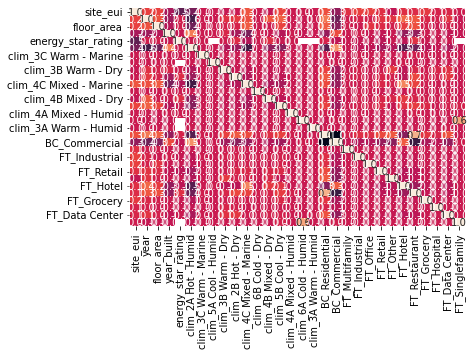

In [46]:
# Correlation heatmap
corr_matrix = dfsmall.corr()

sns.heatmap(corr_matrix, cbar=False, annot=True, fmt='.1f') # , mask=mask)

# Change background to white (invisible)
sns.set(style='white', rc = {'figure.figsize':(15,15)})

# Step 7: Analysis

## For further analysis see separate notebooks



End.
___
